### Statement Classifier

In [1]:
#import libraries
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91812\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#load dataset
df = pd.read_csv("Context.csv")
df

,Text,Context/Topic
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell ...,Love
2,I am such an IDIOT.,Heavy Emotion
3,While lifting weights on Friday and doing bent...,Health
4,Something's watching me,Animals
...,...,...
31381,**TL;DR**,Heavy Emotion
31382,Looks are everything,Heavy Emotion
31383,Teacher: write a thing that you want to do til...,Education
31384,"General Secretary of India's ruling party, the...",Politics


In [4]:
df.shape

(31386, 2)

In [5]:
#check null values
df[df["Context/Topic"].isnull()]

,Text,Context/Topic


In [6]:
df['Text']

0                    The eternal mystique of Goldman Sachs
1        Either you don't care enough to actually tell ...
2                                      I am such an IDIOT.
3        While lifting weights on Friday and doing bent...
4                                  Something's watching me
                               ...                        
31381                                            **TL;DR**
31382                                 Looks are everything
31383    Teacher: write a thing that you want to do til...
31384    General Secretary of India's ruling party, the...
31385    Heastie rewarded contributors, racked up unusu...
Name: Text, Length: 31386, dtype: object

In [7]:
classes = df['Context/Topic'].unique()
classes

array(['Politics', 'Love', 'Heavy Emotion', 'Health', 'Animals',
       'Science', 'Joke', 'Compliment', 'Religion', 'Self', 'Education'],
      dtype=object)

<AxesSubplot:>

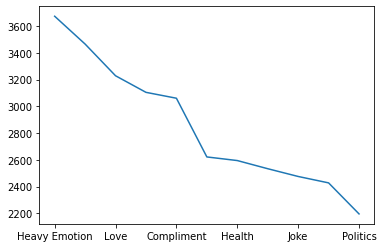

In [8]:
#check counts for each category
df['Context/Topic'].value_counts().plot()

In [9]:
#function to view a single statement
def example_statement(index):
    example = df[df.index == index][['Text', 'Context/Topic']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
        
example_statement(2)

I am such an IDIOT.
Category: Heavy Emotion


In [10]:
#cleaning the text data
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_preprocess(text):
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Text'] = df['Text'].apply(text_preprocess)
df.iloc[12]

Text             nature news blog alex parrots last experiment ...
Context/Topic                                              Science
Name: 12, dtype: object

In [11]:
example_statement(12)

nature news blog alex parrots last experiment shows mathematical genius
Category: Science


In [12]:
# The maximum number of words to be used or words which are having more frequency
MAX_NB_WORDS = 40000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39360 unique tokens.


In [13]:
#tokenize the text data
X_data = tokenizer.texts_to_sequences(df['Text'].values)
X_data = pad_sequences(X_data, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of statement tensor:', X_data.shape)

Shape of statement tensor: (31386, 150)


In [14]:
Y_data = pd.get_dummies(df['Context/Topic']).values
print('Shape of Topic tensor:', Y_data.shape)

Shape of Topic tensor: (31386, 11)


In [15]:
#split the data set

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size = 0.10, random_state = 42)
print("shape of train data: ", X_train.shape,Y_train.shape)
print("shape of test data: ", X_test.shape,Y_test.shape)

shape of train data:  (28247, 150) (28247, 11)
shape of test data:  (3139, 150) (3139, 11)


In [16]:
#create the LSTM model

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_data.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_data.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          4000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 11)                1111      
                                                                 
Total params: 4,081,511
Trainable params: 4,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
#train the model

epochs = 10
batch_size = 32
from keras.callbacks import ModelCheckpoint
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks= [checkpoint,EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)]

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=callbacks)


Epoch 1/10
795/795 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9392
Epoch 00001: val_loss improved from inf to 1.78441, saving model to my_best_model.epoch01-loss1.78.hdf5
795/795 [==============================] - 818s 1s/step - loss: 0.1854 - accuracy: 0.9392 - val_loss: 1.7844 - val_accuracy: 0.6230
Epoch 2/10
795/795 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9441
Epoch 00002: val_loss did not improve from 1.78441
795/795 [==============================] - 830s 1s/step - loss: 0.1685 - accuracy: 0.9441 - val_loss: 1.8588 - val_accuracy: 0.6230
Epoch 3/10
795/795 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9495
Epoch 00003: val_loss did not improve from 1.78441
795/795 [==============================] - 828s 1s/step - loss: 0.1518 - accuracy: 0.9495 - val_loss: 1.9156 - val_accuracy: 0.6106


In [55]:
#check performance with test set

accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

99/99 [==============================] - 15s 147ms/step - loss: 2.0638 - accuracy: 0.5874
Test set
  Loss: 2.064
  Accuracy: 0.587


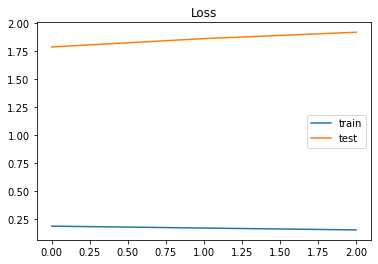

In [56]:
#plot graph of loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

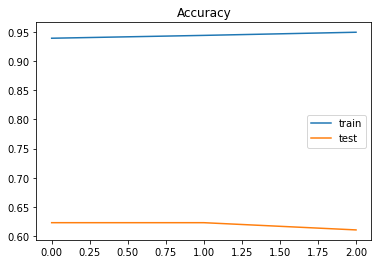

In [57]:
#plot graph of accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [58]:
#make a prediction for new statement
new_statement = ['Passionate love between those two persons']

print(new_statement)
seq = tokenizer.texts_to_sequences(new_statement)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred, classes[np.argmax(pred)])

['Passionate love between those two persons']
[[8.9011110e-02 3.3151913e-02 3.7578540e-04 5.4744305e-04 6.5804725e-03
  2.8331734e-03 8.0846035e-01 4.2253974e-04 5.6735754e-02 1.4872400e-03
  3.9420358e-04]] Joke


In [59]:
classes

array(['Politics', 'Love', 'Heavy Emotion', 'Health', 'Animals',
       'Science', 'Joke', 'Compliment', 'Religion', 'Self', 'Education'],
      dtype=object)

In [60]:
#save the model
import pickle
import joblib

In [62]:
pickle.dump(model, open("saved_model.pkl", "wb"))
model_from_pickle = pickle.load(open("saved_model.pkl",'rb'))


INFO:tensorflow:Assets written to: ram://7db51c58-344d-4838-959c-c8c95fdd27c1/assets


INFO:tensorflow:Assets written to: ram://7db51c58-344d-4838-959c-c8c95fdd27c1/assets


NotFoundError: 

In [47]:
joblib.dump(model,"model_statement.pkl")

INFO:tensorflow:Assets written to: ram://6d7cc54c-2519-4182-ae2d-838487e5a07f/assets


INFO:tensorflow:Assets written to: ram://6d7cc54c-2519-4182-ae2d-838487e5a07f/assets


NotFoundError: 

In [45]:
model_from_pickle = pickle.load(open("model_statement.pkl",'rb'))

EOFError: Ran out of input

In [68]:
new_statement = ['Passionate love between those two persons']

print(new_statement)
seq = tokenizer.texts_to_sequences(new_statement)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model_from_pickle.predict(padded)
print(pred, classes[np.argmax(pred)])

['Passionate love between those two persons']
[[5.0211591e-01 1.5928587e-01 3.9084689e-03 5.1217282e-04 2.2762846e-02
  5.4818294e-03 1.9073389e-01 1.4829956e-02 9.6488133e-02 3.5585794e-03
  3.2240013e-04]] Politics
